# Segmentation

## Data Loader

입력값 과 출력값을 (224, 224) 의 크기를 갖는 모델을 학습 시킬 수 있는 데이터셋을 파싱 합니다.
*파싱이란, 데이터를 읽고 구조화된 형식으로 분석하는 과정을 의미합니다.*

데이터 augmentation (증강) 을 위해서 library 에서 albumentations을 불러 옵니다. 

$ pip list | grep albumentations

학습셋의 일정량을 검증 데이터셋 (validation set)으로 활용 할 수 있도록 하고, 데이터 증강을 위해 아래 자료를 참고 합니다:

1. Keras Sequence에 기반한 Dataloader (https://hwiyong.tistory.com/241)
2. Albumentation을 적용한 Keras sequence (https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac)

데이터를 만든 후에는 직접 데이터셋이 잘 파싱 되어 나오는지를 확인 하고, 데이터셋에 오류가 없는지도 확인 해주세요. 오류가 없지만 성능이 안나와도 상대적으로 문제를 발견 하기 수월합니다. 

In [3]:
# import libraries
import os # 디렉토리 경로 및 파일 처리
import math
import numpy as np # 배열, 수치 계산
import tensorflow as tf # 딥러닝 프레임워크
import PIL
import skimage
import albumentations 

from PIL import Image
import matplotlib.pyplot as plt # 이미지 시각화
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

print('Libraries')

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0
Libraries


## 데이터 augmentation

라이브러리에 불러온 albumentations의 사용법에 관련해서 간단히 알아보겠습니다. 
다음과 같은 코드의 방법으로 Compose() 함수를 활용하여 augmentation 기법을 확률적으로 적용시켜줄 수 있습니다. 

In [4]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

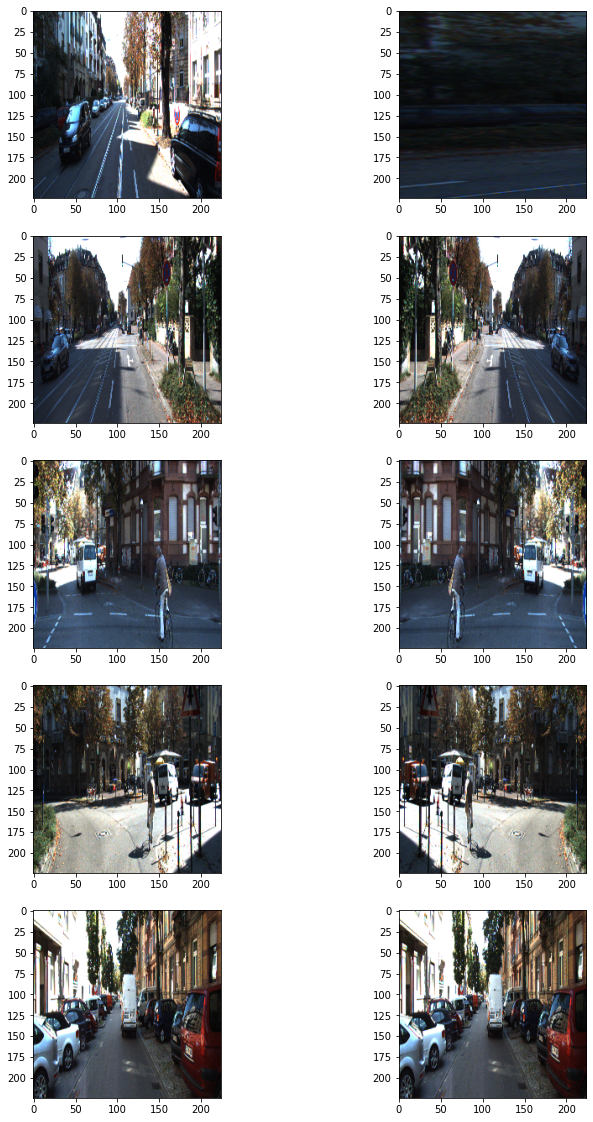

In [5]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

데이터셋을 구성할때, tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성합니다. 

In [6]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequence를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # 데이터셋 로드
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = list(zip(input_images, label_images))

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[
            index * self.batch_size:
            (index + 1) * self.batch_size
        ]

        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8) * 1  # 도로 class = 7

            data = {
                "image": _input,
                "mask": _output,
            }

            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255.0
            outputs[i] = augmented["mask"]

        return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)

In [7]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Semantic Segmentation Model [U-Net]

### U-Net 모델 구조 만들기 
1. Conv2D
2. Conv2DTranspose
3. MaxPooling2D
4. concatenate

In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

# 컨볼루션 블록 정의
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

# U-Net 모델 빌드
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Contracting path
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = conv_block(p4, 1024)

    # Expanding path
    u1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn)
    u1 = concatenate([u1, c4])
    c5 = conv_block(u1, 512)

    u2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c3])
    c6 = conv_block(u2, 256)

    u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c2])
    c7 = conv_block(u3, 128)

    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u4 = concatenate([u4, c1])
    c8 = conv_block(u4, 64)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [9]:
model = build_model(input_shape=(224, 224, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### 모델 학습하기 및 시각화 하기

학습 된 모델을 저장하고 "model = tf.keras.models.load_model(model_path)" 코드를 통해서 불러온 다음, 모델이 추론 (inference) 한 결과를 세그멘테이션 이미지로 시각화를 시켜줍니다.
입력 이미지와 라벨을 한번에 볼 수 있도록 모델의 출력값을 이미지위에 겹처서 (overlay) 보일 수 있는 메소드 를 구현합니다. 이 때 사용하는 함수는 PIL 패키지를 이용하고, get_output 이라는 이름의 함수 ("def get_output(model, preproc, image_path, output_path):")로 만들고 시각화를 해줍니다. 
Segmentation 성능을 정량적으로 평가하기 위해서 Intersection Over Union을 계산하여 overlay 되는 부분과 그렇지 않은 부분을 모델이 예측한 값 (prediction) 과 라벨 데이터의 실제 값 (target) 에 대한 판단 및 결정의 결과에 대한 함수를 구현하고, 위에 구현했던 get_output을 좀 더 확장해서 output, prediction, target을 함께 리턴하도록 구현해 봅시다.

In [8]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 114s 4s/step - loss: 0.6706 - val_loss: 0.6347
Epoch 2/100
11/11 [==============================] - 12s 1s/step - loss: 0.6091 - val_loss: 0.5704
Epoch 3/100
11/11 [==============================] - 11s 931ms/step - loss: 0.5247 - val_loss: 0.4482
Epoch 4/100
11/11 [==============================] - 12s 1s/step - loss: 0.4345 - val_loss: 0.3806
Epoch 5/100
11/11 [==============================] - 12s 1s/step - loss: 0.3417 - val_loss: 0.3295
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 0.3141 - val_loss: 0.3327
Epoch 7/100
11/11 [==============================] - 11s 944ms/step - loss: 0.2953 - val_loss: 0.2787
Epoch 8/100
11/11 [==============================] - 11s 963ms/step - loss: 0.2638 - val_loss: 0.2986
Epoch 9/100
11/11 [==============================] - 11s 965ms/step - loss: 0.2458 - val_loss: 0.2580
Epoch 10/100
11/11 [==============================] - 11s 1s/step - loss: 0.2494 - val_loss: 0.2

Epoch 82/100
11/11 [==============================] - 11s 1s/step - loss: 0.0941 - val_loss: 0.1357
Epoch 83/100
11/11 [==============================] - 10s 872ms/step - loss: 0.0933 - val_loss: 0.1419
Epoch 84/100
11/11 [==============================] - 12s 1s/step - loss: 0.1057 - val_loss: 0.1568
Epoch 85/100
11/11 [==============================] - 11s 949ms/step - loss: 0.0909 - val_loss: 0.1398
Epoch 86/100
11/11 [==============================] - 12s 1s/step - loss: 0.0884 - val_loss: 0.2627
Epoch 87/100
11/11 [==============================] - 12s 1s/step - loss: 0.1005 - val_loss: 0.2019
Epoch 88/100
11/11 [==============================] - 11s 943ms/step - loss: 0.1071 - val_loss: 0.2090
Epoch 89/100
11/11 [==============================] - 11s 941ms/step - loss: 0.1053 - val_loss: 0.1504
Epoch 90/100
11/11 [==============================] - 12s 1s/step - loss: 0.1041 - val_loss: 0.1765
Epoch 91/100
11/11 [==============================] - 11s 1s/step - loss: 0.0976 - val_l

In [10]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [11]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

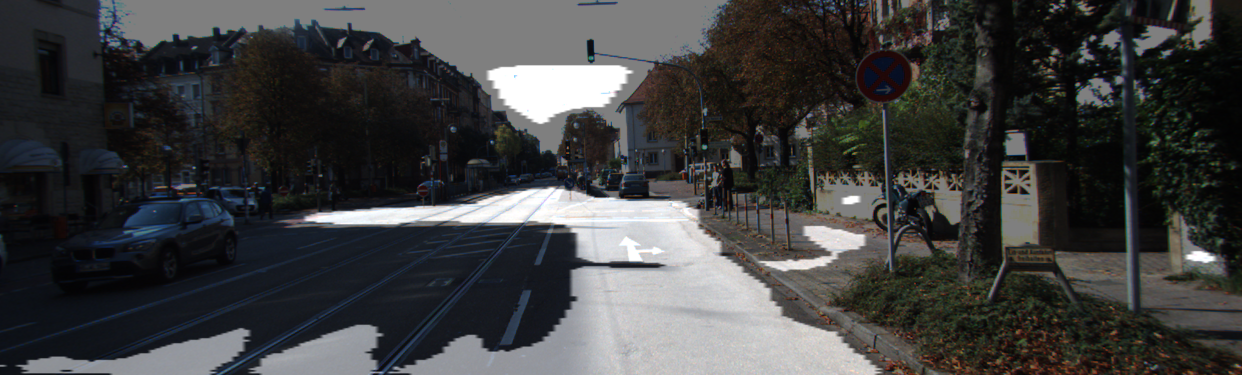

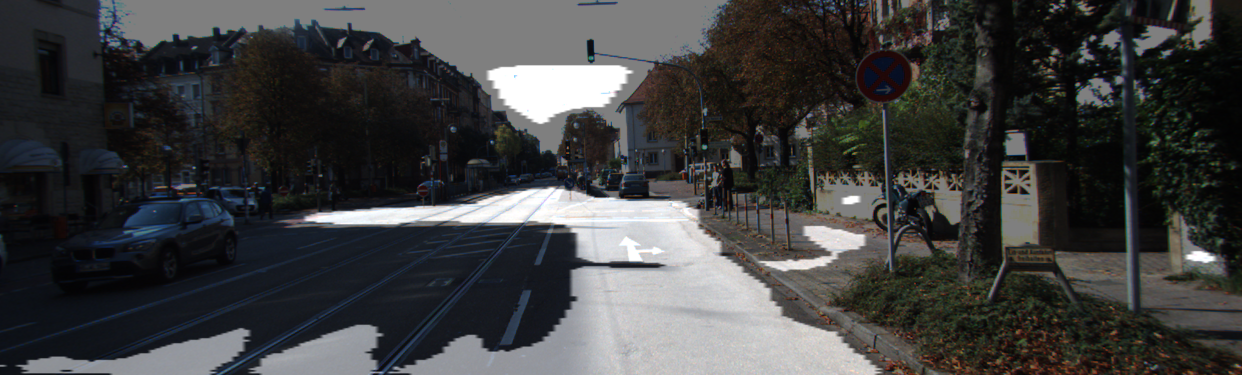

In [12]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [13]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = intersection/union if union != 0 else 0.0
    print('IoU : %f' % iou_score )
    return iou_score

In [14]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

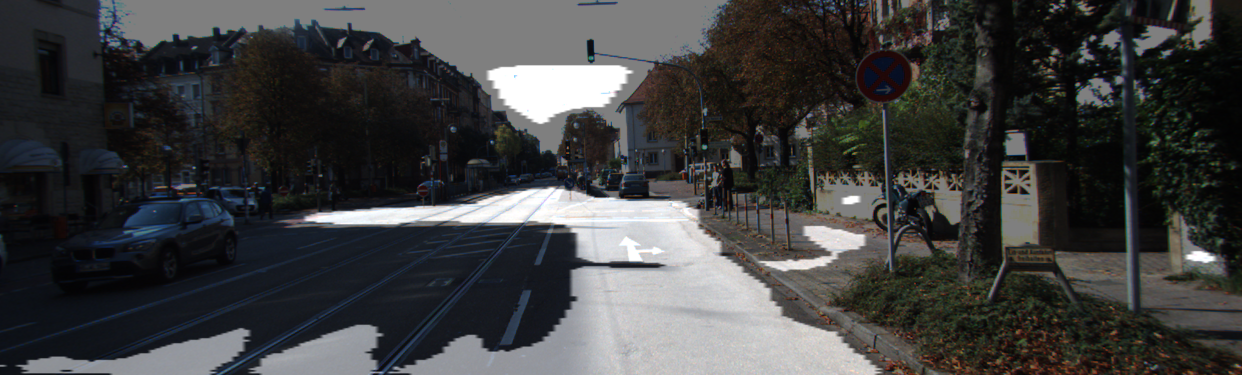

IoU : 0.419641


0.41964089410040306

In [15]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

# Going Deeper Segmentation U-Net vs. U-Net++

## 개선된 U-Net 모델 만들기 

서론

U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느 정도 동작하는 것 같긴 하지만 좀 더 개선할 여지도 보일 것입니다.

2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다. 논문은 2020년에 한 번 업그레이드가 되었네요.

U-Net++ v1: https://arxiv.org/pdf/1807.10165
U-Net++ v2: https://arxiv.org/pdf/1912.05074

모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU 값을 비교해 보면 될 것입니다.

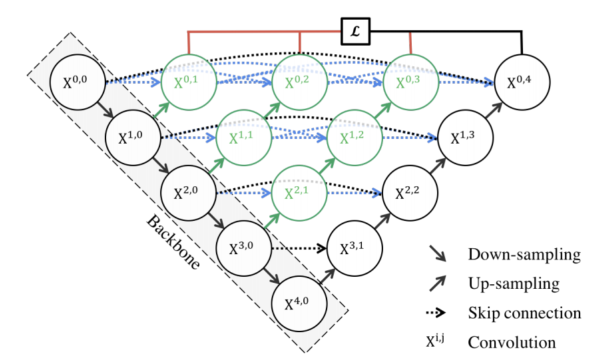

참고할 수 있는 코드는 아래에 있습니다. 다행히도 keras로 구현되어 있습니다.

U-Net++ Git-hub: https://github.com/MrGiovanni/UNetPlusPlus
- bulid_xnet:https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/builder.py#L12


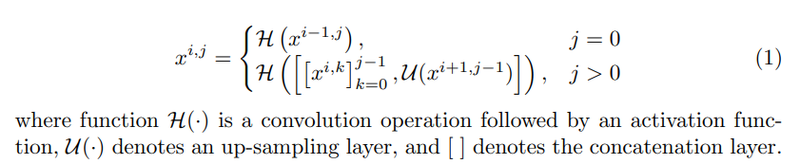

코드 중 up_block으로는 두 가지 방식을 사용하고 있네요. Transpose2D_block과 Upsample2D_block인데요. 둘 중 어느 것을 사용해도 좋습니다.

또 한 가지 주의해야 할 점은 Loss를 조금 다르게 구현해야 한다는 점입니다. binary cross-entropy와 dice coefficient를 사용한다고 하는데요. dice_coef에 구현된 dice coefficient를 참고해 보세요.

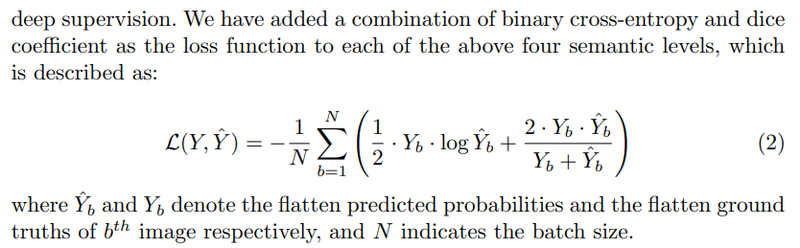

## 목차

1. KITTI 데이터셋 수집과 구축
2. U-Net++ 모델의 구현
3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

In [16]:
# 라이브러리 임포트 및 불러오기 
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

print('go')

go


많은 메모리 사용량과 빠른 처리 작업을 위해서 GPU 사용. 

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## KITTI 데이터셋 수집 과 구축

KITTI 데이터셋을 다운로드 하고 data augmentation을 적용한 형태로 데이터 셋을 구축 합니다. 주의할 점은, U-Net ++ 메모리 사용량은 U-Net 보다 많기 때문에 배치 사이즈를 적절히 사양에 맞게 줄여 사용합니다. 

In [18]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

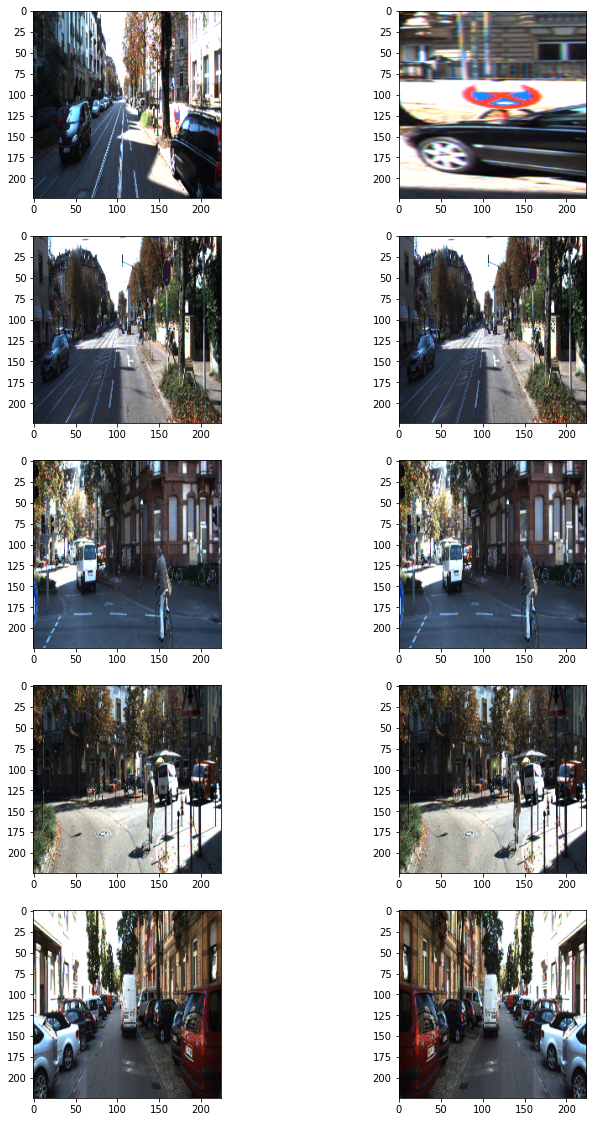

In [19]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

## 데이터셋 구성하기

In [20]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequence를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # 데이터셋 로드
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = list(zip(input_images, label_images))

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[
            index * self.batch_size:
            (index + 1) * self.batch_size
        ]

        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8) * 1  # 도로 class = 7

            data = {
                "image": _input,
                "mask": _output,
            }

            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255.0
            outputs[i] = augmented["mask"]

        return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)

In [21]:
BATCH_SIZE=16

In [22]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path,
    BATCH_SIZE,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    BATCH_SIZE,
    augmentation=test_preproc,
    is_train=False
)

### U-Net 구현 하기

U-Net의 기본 모델 구조:

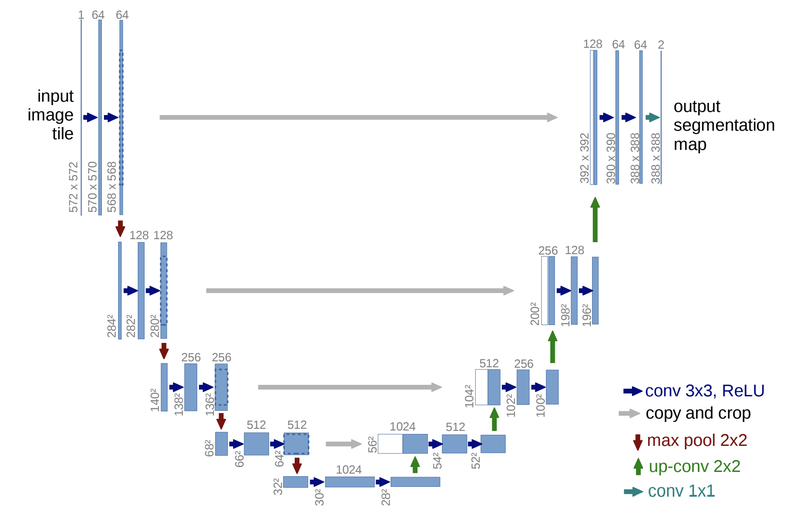

1. Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
2. 추가된 부분은 Batch Normalization (배치 정규화) 를 통해서 학습 속도를 높이고 학습을 안정화 하고 그래디언트 소실 및 폭주를 완하 합니다.
3. 활성화 함수 및 커널을 초기화 시켜주는 방식으로 가중치를 계속 최신으로 업데이트 해줍니다.

In [23]:
epochs = 100

In [24]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.models import Model

# 컨볼루션 블록 정의 (배치 정규화 추가)
def conv_block(input_tensor, num_filters):
    # 첫 번째 컨볼루션 + 배치 정규화 + 활성화
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) # 혹은 x = tf.keras.layers.ReLU()(x)

    # 두 번째 컨볼루션 + 배치 정규화 + 활성화
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) # 혹은 x = tf.keras.layers.ReLU()(x)
    return x

# U-Net 모델 빌드
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Contracting path
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = conv_block(p4, 1024)

    # Expanding path
    u1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn)
    u1 = concatenate([u1, c4])
    c5 = conv_block(u1, 512)

    u2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c3])
    c6 = conv_block(u2, 256)

    u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c2])
    c7 = conv_block(u3, 128)

    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u4 = concatenate([u4, c1])
    c8 = conv_block(u4, 64)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Activation 레이어를 사용하기 위해 추가로 import합니다.
from tensorflow.keras.layers import Activation
# 만약 TensorFlow를 직접 사용한다면 아래와 같이 할 수도 있습니다.
# import tensorflow as tf

In [25]:
#모델 생성
unet = build_model()
#모델 구조
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [26]:
# 2. plot_model 실행 (쓰기 가능한 경로로 지정)
# 현재 작업 디렉토리에 저장하는 예시
file_path = 'U-Net_shapes.png'
try:
    plot_model(unet, to_file=file_path, show_shapes=True, show_layer_names=True)
    print(f"모델 다이어그램이 성공적으로 '{os.path.abspath(file_path)}'에 저장되었습니다.")
    # Jupyter Notebook/Lab 환경이라면 이미지 바로 표시도 가능
    # from IPython.display import Image
    # display(Image(filename=file_path))
except Exception as e:
    print(f"모델 다이어그램 저장 중 오류 발생: {e}")
    print("Graphviz 또는 pydot이 올바르게 설치되어 있는지, 그리고 지정한 경로에 쓸 권한이 있는지 확인해주세요.")

모델 다이어그램이 성공적으로 '/workspace/userdisk/AIFFEL_quest_rs/GoingDeeper/GD07/U-Net_shapes.png'에 저장되었습니다.


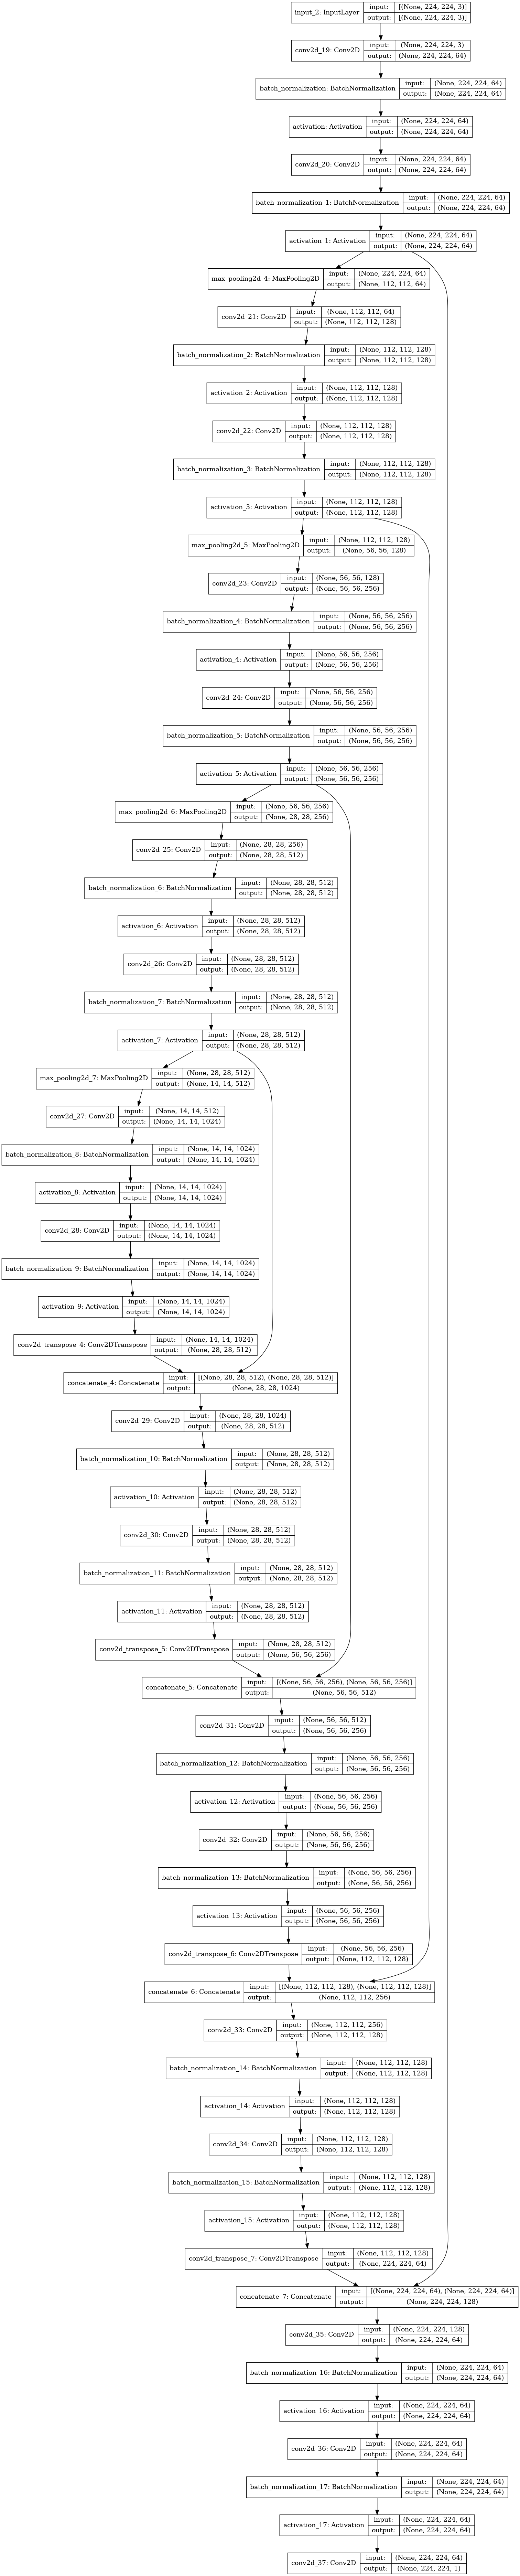

In [27]:
from IPython.display import Image, display
display(Image(filename=file_path))

In [31]:
#모델 학습 
unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])
unet_history = unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
)

Epoch 1/100
11/11 [==============================] - 73s 5s/step - loss: 0.4594 - accuracy: 0.8076 - val_loss: 0.6913 - val_accuracy: 0.4634
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.3376 - accuracy: 0.8868 - val_loss: 0.7085 - val_accuracy: 0.3331
Epoch 3/100
11/11 [==============================] - 11s 918ms/step - loss: 0.2739 - accuracy: 0.9174 - val_loss: 0.7646 - val_accuracy: 0.2318
Epoch 4/100
11/11 [==============================] - 12s 1s/step - loss: 0.2319 - accuracy: 0.9307 - val_loss: 0.7452 - val_accuracy: 0.2327
Epoch 5/100
11/11 [==============================] - 12s 1s/step - loss: 0.2466 - accuracy: 0.9247 - val_loss: 0.9683 - val_accuracy: 0.2303
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 0.2518 - accuracy: 0.9146 - val_loss: 0.7090 - val_accuracy: 0.3341
Epoch 7/100
11/11 [==============================] - 12s 1s/step - loss: 0.2231 - accuracy: 0.9280 - val_loss: 0.6559 - val_accuracy: 0.6326
Epoch 8/10

NameError: name 'unet_path' is not defined

In [33]:
model.save(dir_path)  #학습한 모델을 저장해 주세요.

INFO:tensorflow:Assets written to: ./assets


In [34]:
#학습 결과를 시각화 하기 

def draw_unet_history(history, model_name='U-Net'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(dir_path, f'{model_name}_Result.png'))  # 저장
    plt.show()

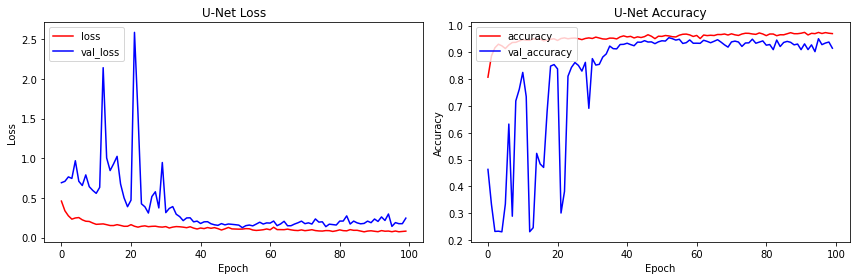

In [35]:
dir_path = '.' # 현재 디렉토리에 저장하도록 설정
draw_unet_history(unet_history, 'U-Net')

In [36]:
UNET_PATH = os.path.join(dir_path, 'seg_model_unet.h5')

In [37]:
unet.save(UNET_PATH)  # 학습한 모델을 저장해 주세요.

다음은 loss 와 accuracy를 보여주는 그래프이며, 학습데이터의 accuracy 같은 경우에는 빨간선을 나타내고 검증데이터의 accuracy 같은 경우에는 파란색선을 나타냅니다. 다음 그래프를 보시게 되면, accuracy 같은 경우에는 꾸준히 상승 하여 높은 수준에 도달 하였고, 이를 해석하면, 학습이 잘 되고 있다는 바를 시사합니다. 검증 accuracy 같은 경우에는 초반에 가파르게 상승 한후 변동성이 점점 줄어들며 빨간색선 (학습 accuracy)와 마찬가지로 높은 수준에 도달 하는 모습을 확인 할 수 있습니다. 하지만 현재 학습 데이터 수준만큼의 정확도는 없음으로 일정 수준의 일반화 성능을 보이지만 과적합 경향이 있거나 아직 과적합임을 시사합니다. 

## U-Net ++ 모델 구현하기


U-Net 모델과 U-Net++ 모델을 비교 하고, 좀더 상세하게 들어가서는 백본 구조 와 하이퍼 파라미터등을 변경 및 조정하여 추가적인 성능 향상이 가능 할 수도 있습니다. 

U-Net++ 의 모델 구조:

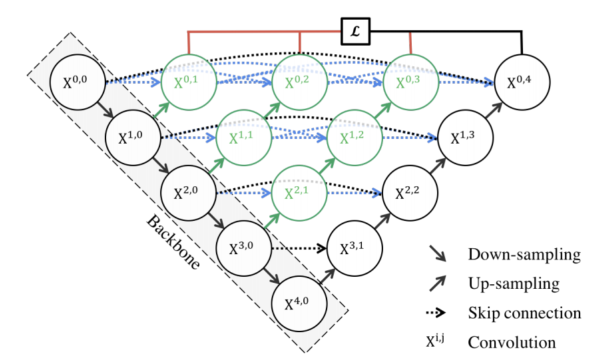

1. U-Net 네트워크 구조 + Dense Net 성능 개선
2. up_block method: Transpose2D_block 과 Upsample2D_block 중 하나 사용
3. Loss: binary cross-entropy + dice coefficient
4. deep supervision: 각 브랜치의 출력(빨간색 선으로 표시된 부분)을 평균해서 최종 결과로서 사용하는 방법 (ensemble method)

In [38]:
def build_unet_pp(input_shape=(224, 224, 3), deep_supervision=True):
    inputs = Input(input_shape)

    filter_list = [64,128,256,512,1024]

    x_00 = conv_block(filter_list[0], inputs)
    x_10 = conv_block(filter_list[1], x_00, to_pool=True)
    x_20 = conv_block(filter_list[2], x_10, to_pool=True)
    x_30 = conv_block(filter_list[3], x_20, to_pool=True)
    x_40 = conv_block(filter_list[4], x_30, to_pool=True)

    x_01 = conv_block(filter_list[0], x_10, [x_00], to_up_concat=True)
    x_11 = conv_block(filter_list[1], x_20, [x_10], to_up_concat=True)
    x_21 = conv_block(filter_list[2], x_30, [x_20], to_up_concat=True)

    x_02 = conv_block(filter_list[0], x_11, [x_00,x_01], to_up_concat=True)
    x_12 = conv_block(filter_list[1], x_21, [x_10,x_11], to_up_concat=True)

    x_03 = conv_block(filter_list[0], x_12, [x_00,x_01,x_02], to_up_concat=True)

    x_31 = conv_block(filter_list[3], x_40, [x_30], to_up_concat=True)
    x_22 = conv_block(filter_list[2], x_31, [x_20], to_up_concat=True)
    x_13 = conv_block(filter_list[1], x_22, [x_10], to_up_concat=True)
    x_04 = conv_block(filter_list[0], x_13, [x_00,x_01,x_02,x_03], to_up_concat=True)

    if deep_supervision:
        x_01_outputs = get_model_outputs(x_01)
        x_02_outputs = get_model_outputs(x_02)
        x_03_outputs = get_model_outputs(x_03)
        x_04_outputs = get_model_outputs(x_04)

        outputs_list = [x_01_outputs, x_02_outputs, x_03_outputs, x_04_outputs]
        outputs = tf.keras.layers.Average()(outputs_list)  # 레이어 모든 값 평균 계산 => sum(outputs_list)/len(outputs_list) 과 결과 같음
    else:
        outputs = get_model_outputs(x_04)

    # U-Net++ 생성
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [39]:
#모델 생성
unetpp = build_model()
#모델 구조
unetpp.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 224, 224, 64) 256         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 224, 224, 64) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [40]:
# 2. plot_model 실행 (쓰기 가능한 경로로 지정)
# 현재 작업 디렉토리에 저장하는 예시
file_path_pp = 'U-Net++_shapes.png'
try:
    plot_model(unetpp, to_file=file_path_pp, show_shapes=True, show_layer_names=True)
    print(f"모델 다이어그램이 성공적으로 '{os.path.abspath(file_path_pp)}'에 저장되었습니다.")
    # Jupyter Notebook/Lab 환경이라면 이미지 바로 표시도 가능
    # from IPython.display import Image
    # display(Image(filename=file_path))
except Exception as e:
    print(f"모델 다이어그램 저장 중 오류 발생: {e}")
    print("Graphviz 또는 pydot이 올바르게 설치되어 있는지, 그리고 지정한 경로에 쓸 권한이 있는지 확인해주세요.")

모델 다이어그램이 성공적으로 '/workspace/userdisk/AIFFEL_quest_rs/GoingDeeper/GD07/U-Net++_shapes.png'에 저장되었습니다.


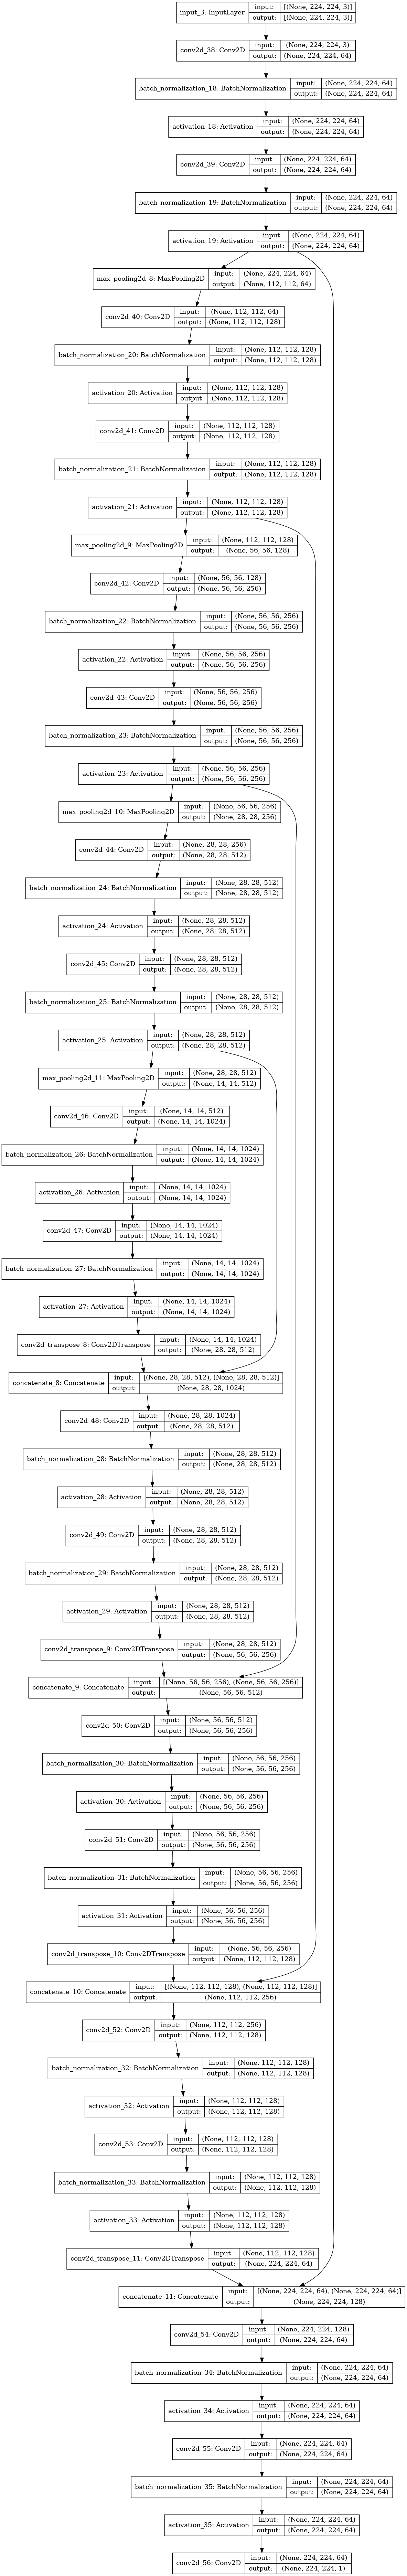

In [41]:
from IPython.display import Image, display
display(Image(filename=file_path_pp))

U-Net ++ 모델 구조
1. Encoder Backbone
2. Dense Skip Connections
3. Nested U-Net
4. Deep Supervision

Balanced Cross Entropy 같은 경우에는 classification 에 사용 하고,
segmentation 같은 경우에는 물체가 작아도 Similarity 가 좋게 나온다는 단점이 있습니다. 
즉, 너무 민감해서 노이즈까지 잡아내거나 중요하지 않은 작은 디테일에 치중하여 전체적인 분할의 질을 해치는 상황을 마주할 수 있습니다.
따라서 이부분을 완하하기 위해서 Weighted Cross Entropy 나 Balanced Cross Entropy를 적용 할 수 있습니다. 


In [42]:
#모델 학습 
from keras import backend as K

# Custom Metrics
def dice_coef(y_true, y_pred): # dice coefficient
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Custom loss function
def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred): # Balanced cross entropy + Dice Coefficient Loss 
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [43]:
unetpp.compile(
    optimizer = Adam(1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

unetpp_history = unetpp.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
)

Epoch 1/100
11/11 [==============================] - 22s 2s/step - loss: -0.0940 - dice_coef: 0.4354 - val_loss: 0.0342 - val_dice_coef: 0.3167
Epoch 2/100
11/11 [==============================] - 11s 914ms/step - loss: -0.2775 - dice_coef: 0.5328 - val_loss: 0.0688 - val_dice_coef: 0.3430
Epoch 3/100
11/11 [==============================] - 10s 907ms/step - loss: -0.4798 - dice_coef: 0.6575 - val_loss: 0.1253 - val_dice_coef: 0.3840
Epoch 4/100
11/11 [==============================] - 10s 899ms/step - loss: -0.4449 - dice_coef: 0.6391 - val_loss: 0.3811 - val_dice_coef: 0.3878
Epoch 5/100
11/11 [==============================] - 10s 900ms/step - loss: -0.5588 - dice_coef: 0.7096 - val_loss: 0.0855 - val_dice_coef: 0.4204
Epoch 6/100
11/11 [==============================] - 14s 1s/step - loss: -0.5783 - dice_coef: 0.7266 - val_loss: 0.8189 - val_dice_coef: 0.3944
Epoch 7/100
11/11 [==============================] - 14s 1s/step - loss: -0.5870 - dice_coef: 0.7265 - val_loss: 0.5459 - va

Epoch 57/100
11/11 [==============================] - 11s 961ms/step - loss: -0.8025 - dice_coef: 0.8646 - val_loss: -0.7336 - val_dice_coef: 0.8278
Epoch 58/100
11/11 [==============================] - 12s 1s/step - loss: -0.7962 - dice_coef: 0.8600 - val_loss: -0.7485 - val_dice_coef: 0.8321
Epoch 59/100
11/11 [==============================] - 13s 1s/step - loss: -0.8032 - dice_coef: 0.8614 - val_loss: -0.7483 - val_dice_coef: 0.8316
Epoch 60/100
11/11 [==============================] - 11s 936ms/step - loss: -0.8096 - dice_coef: 0.8708 - val_loss: -0.7299 - val_dice_coef: 0.8340
Epoch 61/100
11/11 [==============================] - 12s 1s/step - loss: -0.8076 - dice_coef: 0.8696 - val_loss: -0.6764 - val_dice_coef: 0.8003
Epoch 62/100
11/11 [==============================] - 11s 960ms/step - loss: -0.8186 - dice_coef: 0.8786 - val_loss: -0.7448 - val_dice_coef: 0.8317
Epoch 63/100
11/11 [==============================] - 11s 944ms/step - loss: -0.8001 - dice_coef: 0.8611 - val_loss

In [44]:
#학습 결과를 시각화 하기 

def draw_unetpp_history(unetpp_history, model_name='U-Net_Plus'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(unetpp_history.history['loss'], 'r')
    plt.plot(unetpp_history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation dice coefficient 시각화
    plt.subplot(122)
    plt.plot(unetpp_history.history['dice_coef'], 'r')
    plt.plot(unetpp_history.history['val_dice_coef'], 'b')
    plt.title(f'{model_name} dice_coef')
    plt.ylabel('dice_coef')
    plt.xlabel('Epoch')
    plt.legend(['dice_coef', 'val_dice_coef'], loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(dir_path, f'{model_name}_Result1.png'))  # 저장
    plt.show()

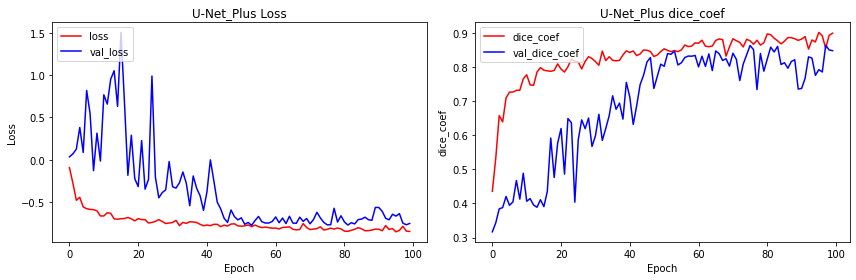

In [45]:
dir_path = '.' # 현재 디렉토리에 저장하도록 설정
draw_unetpp_history(unetpp_history, 'U-Net_Plus')

In [46]:
UNETpp_PATH = os.path.join(dir_path, 'seg_model_unetpp.h5')

In [47]:
unetpp.save(UNETpp_PATH)  # 학습한 모델을 저장해 주세요.

현재 평가된 지표로써, validation loss 와 validation dice coefficient 함수를 구현하여 metrics 지표로 사용 하였습니다. Image segmentation에서는 accuracy (정확도) 보다는 dice 계수가 좀 더 중요한 평가 지표로써의 의미를 갖습니다. 
Dice Coefficient 같은 경우에는 다음과 같은 수식으로 표현이 가능합니다:
2 * (교집합 크기) / (실제 마스크 크기 + 예측 마스크 크기). 따라서 실제 객체의 영역과 예측된 객체 영역이 얼마나 잘 겹치는지를 정량적으로 평가 (Intersection Over Union; IoU) 할 수 있는 지표로 활용되고, 객체 분할의 정밀도 와 재현율을 종합적으로 평가도 가능합니다. 

다음 그래프를 보시면 빨간색 선이 나타내는것은 학습 데이터의 dice 계수이고 파란색 선이 나타내는것은 검증 데이터의 dice 계수 인걸 알 수 있습니다. 학습 데이터의 dice 계수 같은 경우에는 꾸준히 상승하여 어느정도 threshold point에 도달하면 서서히 학습을 천천히 진행 하는 걸 확인 할 수 있고, 검증 dice 계수 같은 경우에는 초반에 빠르게 상승하다가 어느 threshold point에 도달한 약간의 상승곡선을 반복하며 학습이 어느지점에 정체 되는 것을 확인 할 수 있습니다. 이 결과가 시사하는 바는 모델이 어느 한계점에서 일반화 성능의 한계에 이미 도달하였고, 이 부분의 한계점을 극복 하기 위해서는 hyper-paramter 조정등을 통해서 학습 데이터 와 검증 데이터의 간격을 조정 해주면서 일반화 성능을 올리면 된다고 생각합니다. 

## U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
U-Net vs. U-Net ++ 을 정량적으로 평가 비교 하여 시각화 와 Intersection over Union (IoU)를 계산하여 정성적 성능의 차이를 알 수 있습니다.

In [75]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    return iou_score

In [76]:
def get_output(model, preproc, image_path, output_path_dict, label_path, to_visualize=False):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역

    output_detect = Image.fromarray(output)
    output_detect = output_detect.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output_detect.save(output_path_dict['detect'], 'png')  # 저장 # 도로 detection

    background = Image.fromarray(origin_img).convert('RGBA')
    output_blend = Image.blend(background, output_detect, alpha=0.5)
    output_blend.save(output_path_dict['blend'], 'png')  # 저장 # 도로 detection + 원본 이미지

    if to_visualize:
        # 시각화 및 저장
        plt.figure(figsize=(12,6))

        plt.subplot(211)
        plt.title('Detection')
        plt.axis('off')
        plt.imshow(output_detect)

        plt.subplot(212)
        plt.title('Blend')
        plt.axis('off')
        plt.imshow(output_blend)

        plt.tight_layout()
        plt.savefig(output_path_dict['all'])  # 저장 # 이미지 2개 같이 저장
        plt.show()
    
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로(7)로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [77]:
unet = tf.keras.models.load_model(UNET_PATH)

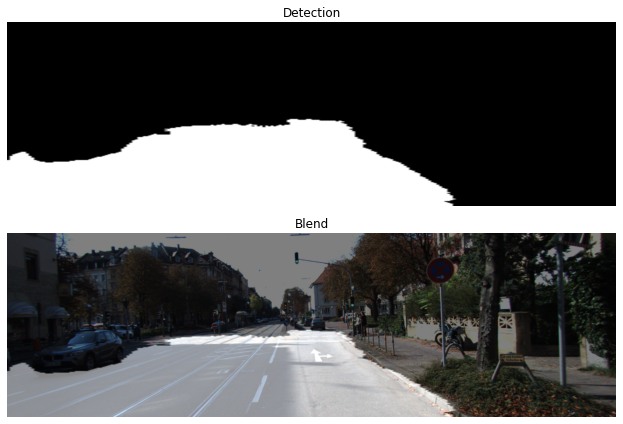

In [80]:
output_dir = os.getenv('HOME') + '/aiffel/semantic_segmentation/results' # Or any other writable path
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

i = 1
output_unet, prediction_unet, target_unet = get_output(
    unet,
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path_dict={
        'detect': os.path.join(output_dir, f'unet_result_{str(i).zfill(3)}_detect.png'),
        'blend': os.path.join(output_dir, f'unet_result_{str(i).zfill(3)}_blend.png'),
        'all': os.path.join(output_dir, f'unet_result_{str(i).zfill(3)}_all.png'),
    },
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
    to_visualize=True,
)

In [81]:
unet_iou = calculate_iou_score(target_unet, prediction_unet)
unet_iou

0.924745969898388

In [82]:
unet_pp = tf.keras.models.load_model(UNETpp_PATH, compile=False)

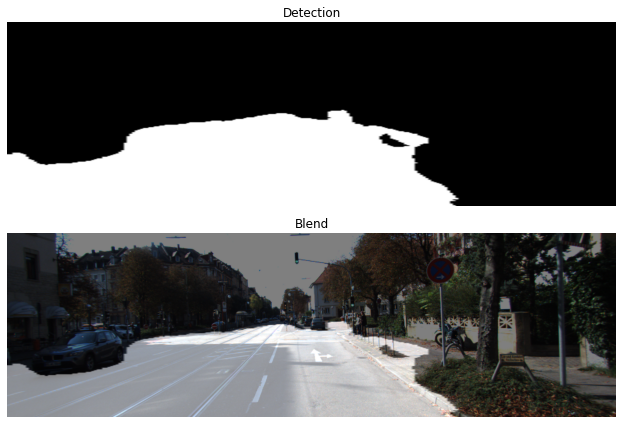

In [85]:
output_save_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'semantic_segmentation', 'results_unet_plus_plus')
os.makedirs(output_save_dir, exist_ok=True) # 디렉토리가 없으면 생성

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.
output_unet_pp, prediction_unet_pp, target_unet_pp = get_output(
    unet_pp,
    test_preproc, # 이전에 정의된 test_preproc 변수 사용
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path_dict={
        'detect': os.path.join(output_save_dir, f'unet++_result_{str(i).zfill(3)}_detect.png'),
        'blend': os.path.join(output_save_dir, f'unet++_result_{str(i).zfill(3)}_blend.png'),
        'all': os.path.join(output_save_dir, f'unet++_result_{str(i).zfill(3)}_all.png'),
        },
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
    to_visualize=True, # 이 인자는 get_output 함수 정의에 따라 사용됩니다.
)

# print("U-Net++ 모델 시각화 및 저장 완료 (오류가 없다면)")


In [87]:
unet_pp_iou = calculate_iou_score(target_unet_pp, prediction_unet_pp)
unet_pp_iou

0.8896011396011396

### 테스트 이미지 확인

추론 결과 저장 및 Intersection over Union (IoU) 계산

In [104]:
import os
import numpy as np
# Assuming calculate_iou_score, get_output, test_preproc, dir_path, unet, unet_pp are defined
# Make sure your get_output function uses the output_path_dict to save files.

def visualize_inference_and_get_iou(model, model_name, base_output_dir, image_data_list, to_visualize=False):
    """
    Processes images, saves outputs to a writable directory, calculates IoU.

    Args:
        model: The Keras model for inference.
        model_name: String name for the model (e.g., 'unet', 'unet_plus_plus').
        base_output_dir: The base writable directory for results.
        image_data_list: A list of (image_path, label_path) tuples (e.g., test_generator.data).
        to_visualize: Boolean, whether to show blended images (if get_output supports it).
    Returns:
        A dictionary {image_filename: iou_score}.
    """
    iou_scores = {}
    
    # Create a specific subdirectory for this model's results within the writable base_output_dir
    model_specific_output_dir = os.path.join(base_output_dir, model_name)
    os.makedirs(model_specific_output_dir, exist_ok=True) # Crucial step!

    print(f"\n--- {model_name.upper()} 모델 평가 및 시각화 (결과 저장 경로: {model_specific_output_dir}) ---")
    for image_path, label_path in image_data_list:
        image_basename = os.path.basename(image_path) # e.g., 000001_10.png
        # Use a consistent naming for the output files, perhaps derived from image_basename
        file_prefix = image_basename.split('_')[0] # e.g., 000001 if filename is 00xxxx_yy.png

        output_path_dict_for_saving = {
            'detect': os.path.join(model_specific_output_dir, f'{file_prefix}_detect.png'),
            'blend': os.path.join(model_specific_output_dir, f'{file_prefix}_blend.png'),
            'all': os.path.join(model_specific_output_dir, f'{file_prefix}_all.png'),
        }

        # Ensure get_output uses output_path_dict for saving
        # and test_preproc is the correct preprocessing function
        blended_img, prediction_mask, target_mask = get_output(
            model,
            test_preproc, 
            image_path=image_path,
            output_path_dict=output_path_dict_for_saving, # Pass the new writable paths
            label_path=label_path,
            to_visualize=to_visualize,
        )

        if target_mask is not None and prediction_mask is not None:
            iou = calculate_iou_score(target_mask, prediction_mask)
            iou_scores[image_basename] = iou
        else:
            print(f"Warning: {label_path} 또는 예측에 대한 마스크를 로드/생성할 수 없습니다.")
            
    return iou_scores

# --- Example Usage ---
# 1. Define your base writable output directories (outside the function)
results_dir_unet = os.path.join(os.getenv('HOME'), 'aiffel', 'semantic_segmentation', 'results')
results_dir_unet_pp = os.path.join(os.getenv('HOME'), 'aiffel', 'semantic_segmentation', 'results_unet_plus_plus')



In [106]:
# dir_path should still point to your input data:
dir_path = os.getenv('HOME') + '/aiffel/semantic_segmentation/data/training'

# Call for U-Net
unet_iou_dict = visualize_inference_and_get_iou(
    model=unet,
    model_name='unet',
    base_output_dir=results_dir_unet,  # Pass the writable base directory
    image_data_list=test_generator.data,  # Pass the list of data
    to_visualize=False
)

if unet_iou_dict:
    print(f"U-Net 평균 IoU: {np.mean(list(unet_iou_dict.values()))}")

# Call for U-Net++ (similarly)
unet_pp_iou_dict = visualize_inference_and_get_iou(
    model=unet_pp,
    model_name='unet_plus_plus',
    base_output_dir=results_dir_unet_pp,  # Pass the writable base directory
    image_data_list=test_generator.data,  # Pass the list of data
    to_visualize=False
)

if unet_pp_iou_dict:
    print(f"U-Net++ 평균 IoU: {np.mean(list(unet_pp_iou_dict.values()))}")


--- UNET 모델 평가 및 시각화 (결과 저장 경로: /aiffel/aiffel/semantic_segmentation/results/unet) ---
U-Net 평균 IoU: 0.7094425999223997

--- UNET_PLUS_PLUS 모델 평가 및 시각화 (결과 저장 경로: /aiffel/aiffel/semantic_segmentation/results_unet_plus_plus/unet_plus_plus) ---
U-Net++ 평균 IoU: 0.7962579535747767


결론: 평균 IoU 값을 U-Net 모델 과 U-Net++ 모델을 비교 했을 때, U-Net++ > U-Net 모델 보다 더 높은 성능을 보여주었습니다. 따라서 U-Net++ 모델이 전반적으로 U-Net 모델 보다 도로 영역을 더 정확하게 segmentation 했음을 시시사하고 U-Net++ 모델 같은 경우에는 U-Net의 기본 구조에 개선된 스킵 연결 (skip connections) 과 deep supervision등을 추가하여, 객체의 경계를 더 잘 포착하고 다양한 크기의 특징등을 효과적으로 학습 할 수 있도록 설계 되었기 때문에, 이러한 구조적 개선이 더 나은 IoU 값으로 이어진 점을 확인 할 수 있었습니다. 

## 평가 및 회고 

루브릭
아래의 기준을 바탕으로 프로젝트를 평가합니다.
평가문항	상세기준
1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?	KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.
2. U-Net++ 모델이 성공적으로 구현되었는가?	U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.
3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?	U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

이번 프로젝트를 진행하면서 평가 지표로는 BCE (Balanced Cross Entropy) 와 Dice Coefficient를 같이 사용해 주었습니다. 이 두가지 지표를 사용함으로써 모델의 픽셀 분류 정확도와 영역 중첩 성능을 종합적으로 평가 할 수 있었고, segmetation 모델의 성능을 조금 더 다각적인 방면으로 이해하는데 도움이 될 수 있었던것 같습니다. 다각적이라 함은, 픽셀 단위의 정확성 과 영역 기반 유사성을 종합적으로 파악 할 수 있다는 점을 설명할 수 있습니다. 

픽셀 단위 정확성 같은 경우에는, BCE가 각 픽셀이 올바른 클래스로 분류가 되었는지 초점을 맞추고, 개별 픽셀 수준에서 모델이 얼마나 정확하게 예측하는지를 측정함으로, 모델 분류 성능의 이해를 돕습니다.
영역 기반 유사성 같은 경우에는, Dice Coefficient (다이스 계수) 가 픽셀 단위 정확성을 넘어서 예측된 영역과 실제 영역이 전체적으로 얼마나 잘 겹치는지를 평가해주고 이 측면에서는 segmentation의 주요 목표인 '객체의 형태와 위치를 정확하게 파악을 했는가?'를 측정하는데 효과적입니다. 또한 클래스 불균형인 데이터셋에도 유용하게 사용할 수 있습니다. 

따라서 이 두가지 지표를 함께 쓰면 모델이 개별 픽셀을 얼마나 잘 맞출 수 있는지와 모델이 예측한 전체 영역의 모양과 크기가 실제와 얼마나 유사한지에 대한 두가지 측면에서 모델의 성능을 종합적으로 파악 할 수 있습니다. 

한가지 이 공부에서 아쉬운점은 HD (Hausdorff Distance)를 지표에 같이 추가 하여 사용하지 못한점에서 아쉬움이 있습니다. 하우스도르프 거리는 segmentation 결과를 평가하는 또하나의 중요한 지표로 사용할 수 있으며, 이를 앞에 설명한 두개의 지표와 더하여 설명한다면 조금 더 다각적인 해석과 분석이 가능합니다. 하우스도르프 거리의 정의는 두 점 집합 간의 최대 불일치 정도를 측정하는 방법입니다. 즉 segmentation 에서는 예측된 경계와 실제 경계 사이의 거리를 평가하는데 사용하고 두 경계가 얼마나 떨어져 있는지를 정량화 해서 수치로 나타낼수 있는 값으로, HD 값이 작을수록 두경계가 가깝고 유사하다는 의미로 해석 할 수 있습니다. 

따라서 수식으로는 이렇게 표현 할 수 있습니다:
H (A,B) = max(max 
a∈A
​
 min 
b∈B
​
 ∥a−b∥,max 
b∈B
​
 min 
a∈A
​
 ∥b−a∥)
 
예를 들면, 두 개의 해안선, 해안선 A (실제 모양)와 해안선 B (내가 그린 모양)가 있다고 상상해 보세요. 이 두 해안선이 얼마나 비슷한지, 특히 가장 크게 어긋난 부분이 어디인지 알고 싶습니다.

해안선 A의 모든 지점에서 해안선 B까지 가장 가까운 지점까지의 거리를 각각 측정합니다. 이렇게 측정한 거리들 중에서 가장 큰 값을 찾습니다. 이 값이 바로 "해안선 A에서 해안선 B로의 최대 오차"입니다. 이 지점이 해안선 A에서 봤을 때, 내가 그린 해안선 B와 가장 멀리 떨어진, 가장 크게 잘못 그린 부분입니다. 
 
이번에는 반대로 해안선 B의 모든 지점에서 해안선 A까지 가장 가까운 지점까지의 거리를 각각 측정합니다. 마찬가지로, 이 거리들 중에서 가장 큰 값을 찾습니다. 이것이 "해안선 B에서 해안선 A로의 최대 오차"입니다.

최종 하우스도르프 거리: 위에서 구한 두 개의 "최대 오차" 값 (A에서 B로의 최대 오차, B에서 A로의 최대 오차) 중에서 더 큰 값을 최종적인 하우스도르프 거리로 선택합니다.

따라서 이 지표까지 더한다면 Dice/IoU 가 전반적인 overlay 된 정도를 알려주는 반면 하우스도르프 거리는 국소적인 오차의 범위까지 민감하게 반응하기에 경계의 정밀도가 중요한 경우에 유용하게 사용할 수 있습니다. 